## Augmentation을 활용한 챗봇 만들기

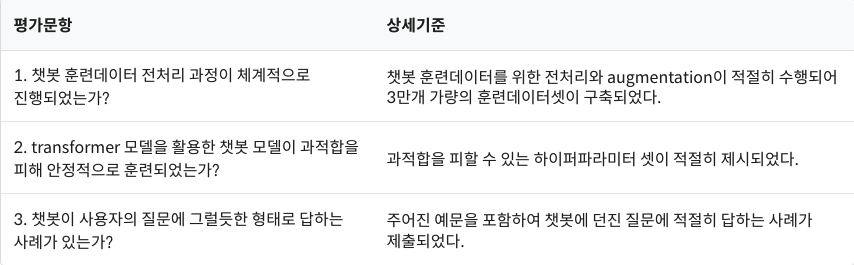

In [1]:
!pip install gensim==3.8.1

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import gensim
from konlpy.tag import Mecab
import re
import random
from tqdm import tqdm_notebook
from collections import Counter


print(np.__version__)
print(pd.__version__)
print(tf.__version__)
print(nltk.__version__)
print(gensim.__version__)

1.21.4
1.3.3
2.6.0
3.6.5
3.8.1


In [3]:
chat = pd.read_csv('~/data/ChatbotData .csv')
chat

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


### 데이터 정제/토큰화

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 숫자, 영어 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣|a-z|A-Z|0-9|?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [5]:
#서브워드용 정제
questions,answers = [],[]

for sen in chat['Q']:
    sen = preprocess_sentence(sen)
    questions.append(sen)
for sen in chat['A']:
    sen = preprocess_sentence(sen)
    answers.append(sen)

In [10]:
def token(sen):
    que_corpus = []
    ans_corpus = []
    
    for i in range(0, len(sen)):
        mecab = Mecab()
        
        q, a,_ = sen.loc[i]
        
        q = preprocess_sentence(q)
        q = mecab.morphs(q)
#         q = [word for word in q if not word in stopwords]
        
        a = preprocess_sentence(a)
        a = mecab.morphs(a)
#         a = [word for word in a if not word in stopwords]
        
        if len(q) < 20 and len(a) < 20: #일정 길이 이상 제외
            if q not in que_corpus:
                if a not in ans_corpus: #소스와 타겟별 중복 검사
                    que_corpus.append(q)
                    ans_corpus.append(a)
    
    return que_corpus, ans_corpus

In [11]:
que_corpus, ans_corpus = token(chat)

In [12]:
len(que_corpus)

7517

In [13]:
len(ans_corpus)

7517

### 데이터 증강

In [14]:
word2vec = gensim.models.Word2Vec.load('./ko.bin')

In [15]:
def lexical_sub(sentence, word2vec):
    

    res = []
    toks = sentence

    try:
        _from = random.choice(toks)
        _to = word2vec.most_similar(_from)[0][0]

    except:   # 단어장에 없는 단어
        return sentence

    for tok in toks:
        if tok is _from: res.append(_to)
        else: res.append(tok)

    return res

In [16]:
que_corpus[51],lexical_sub(que_corpus[51],word2vec)

/tmp/ipykernel_388/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


(['같이', '할', '수', '있', '는', '취미', '생활', '뭐', '있', '을까'],
 ['같', '할', '수', '있', '는', '취미', '생활', '뭐', '있', '을까'])

In [17]:
src_corpus = []
tgt_corpus = []

for i in (range(len(que_corpus))):
    que_sen = lexical_sub(que_corpus[i], word2vec)
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_388/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [18]:
for i in (range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = lexical_sub(ans_corpus[i], word2vec)
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

/tmp/ipykernel_388/503012188.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  _to = word2vec.most_similar(_from)[0][0]


In [19]:
for i in (range(len(que_corpus))):
    que_sen = que_corpus[i]
    ans_sen = ans_corpus[i]
    src_corpus.append(que_sen)
    tgt_corpus.append(ans_sen)

In [20]:
print(len(src_corpus))
print(len(tgt_corpus))

22551
22551


In [21]:
src_corpus

[['12', '시', '땡', '캐치'],
 ['1', '지망', '학교의', '떨어졌', '어'],
 ['3', '박', '4', '일', '놀', '러', '가', '고', '싶', '다'],
 ['ppl', '강하', '네'],
 ['sd', '카드', '망가졌', '어'],
 ['sns', '맞', '팔', '왜', '안', '시키', '지'],
 ['sns', '시간', '낭비', '인은', '거', '아', '는데', '매일', '하', '는', '중'],
 ['sns', '살펴보', '면', '나', '만', '빼', '고', '다', '행복', '해', '보여'],
 ['가끔', '궁금하', '해'],
 ['이따금', '은', '혼자', '인', '게', '좋', '다'],
 ['부유', '한', '자', '의', '설움'],
 ['가만', '있', '어도', '땀', '난다'],
 ['가상', '화폐', '쫄딱', '망함'],
 ['가스', '불', '켜', '고', '나갔', '어'],
 ['증기', '비', '너무', '많이', '나왔', '다', '.'],
 ['가스', '비', '비싼데', '달라붙', '걸리', '겠', '어'],
 ['가족', '항해', '가', '기', '로', '했', '어'],
 ['가족', '적과', '여행', '간다', '.'],
 ['가족', '부유층', '보', '고', '싶', '어'],
 ['가족', '들', '아줌마', '서먹', '해'],
 ['가족', '들', '아줌마', '여행', '갈', '거', '야'],
 ['친지', '한테', '스트레스', '풀', '었', '어'],
 ['가출', '할까', '...'],
 ['가출', '해도', '갈', '데', '가', '없', '어서'],
 ['간만에', '일그러지', '니까', '좋', '더라'],
 ['간만에', '쇼핑', '중의'],
 ['간만에', '휴식', '중'],
 ['간식', '뭐', '씹', '을까'],
 ['간장', '아이스크림

### 데이터 벡터화

In [22]:
que_data = []

for sen in tgt_corpus:
    sen = ["<start>"] + sen + ["<end>"]
    que_data.append(sen)
que_data[:10]

[['<start>', '하루', '가', '또', '가', '네요', '.', '<end>'],
 ['<start>', '위로', '해', '드립니다', '.', '<end>'],
 ['<start>', '여행', '은', '언제나', '좋', '죠', '.', '<end>'],
 ['<start>', '눈살', '이', '찌푸려', '지', '죠', '.', '<end>'],
 ['<start>', '다시', '새로', '사', '는', '게', '마음', '편해요', '.', '<end>'],
 ['<start>', '잘', '모르', '고', '있', '을', '수', '도', '있', '어요', '.', '<end>'],
 ['<start>', '시간', '을', '정하', '고', '해', '보', '세요', '.', '<end>'],
 ['<start>', '자랑', '하', '는', '자리', '니까요', '.', '<end>'],
 ['<start>', '그', '사람', '도', '그럴', '거', '예요', '.', '<end>'],
 ['<start>', '혼자', '를', '즐기', '세요', '.', '<end>']]

In [23]:
total_data = que_data + src_corpus

len(total_data)

45102

In [24]:
words = np.concatenate(total_data).tolist()
counter = Counter(words)
counter = counter.most_common(30000-2)
vocab = ['<pad>', '<unk>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}
index_to_word = {index:word for word, index in word_to_index.items()}

In [25]:
word_to_index

{'<pad>': 0,
 '<unk>': 1,
 '.': 2,
 '<start>': 3,
 '<end>': 4,
 '이': 5,
 '는': 6,
 '하': 7,
 '을': 8,
 '가': 9,
 '세요': 10,
 '좋': 11,
 '고': 12,
 '어': 13,
 '거': 14,
 '있': 15,
 '은': 16,
 '해': 17,
 '보': 18,
 '지': 19,
 '?': 20,
 '나': 21,
 '아': 22,
 '도': 23,
 '게': 24,
 '겠': 25,
 '는데': 26,
 '에': 27,
 '사람': 28,
 '예요': 29,
 '사랑': 30,
 '어요': 31,
 '를': 32,
 '죠': 33,
 '같': 34,
 '한': 35,
 '네': 36,
 '다': 37,
 '것': 38,
 '없': 39,
 '수': 40,
 '면': 41,
 '네요': 42,
 '싶': 43,
 '의': 44,
 '안': 45,
 '봐요': 46,
 '친구': 47,
 '생각': 48,
 '않': 49,
 '마음': 50,
 '말': 51,
 '아요': 52,
 '할': 53,
 '너무': 54,
 '되': 55,
 '이별': 56,
 '했': 57,
 '잘': 58,
 '주': 59,
 '남자': 60,
 '었': 61,
 '더': 62,
 '내': 63,
 '연락': 64,
 '일': 65,
 '기': 66,
 '만': 67,
 '여자': 68,
 '들': 69,
 '힘들': 70,
 '해요': 71,
 '남': 72,
 '시간': 73,
 '썸': 74,
 '많이': 75,
 '길': 76,
 '짝': 77,
 '으로': 78,
 '한테': 79,
 '으면': 80,
 '았': 81,
 '괜찮': 82,
 '건': 83,
 '때': 84,
 '좀': 85,
 '에요': 86,
 '에서': 87,
 '에게': 88,
 '요': 89,
 '야': 90,
 '만나': 91,
 '그': 92,
 '많': 93,
 '알': 94,
 '받': 95,
 '습

In [26]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index['<unk>'] for word in sentence]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<unk>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data

In [27]:
enc_train = vectorize(src_corpus, word_to_index)
dec_train = vectorize(que_data, word_to_index)

In [28]:
print(len(enc_train))
print(len(dec_train))
print(enc_train[0])
print(dec_train[0])

22551
22551
[2473, 214, 3222, 864]
[3, 283, 9, 136, 9, 42, 2, 4]


In [29]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(enc_train,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=20)

dec_train = tf.keras.preprocessing.sequence.pad_sequences(dec_train,
                                                       value=word_to_index["<pad>"],
                                                       padding='pre',
                                                       maxlen=22)

### 모델함수 구성

In [30]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table


In [31]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)

        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions


    def split_heads(self, x):
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x


    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)

        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)

        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

In [33]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.fc2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.fc1(x)
        out = self.fc2(out)

        return out

In [34]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, enc_attn

In [35]:
class Encoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask):
        out = x

        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)

        return out, enc_attns

In [36]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)

    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.dec_self_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [37]:
class Decoder(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]


    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x

        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [38]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

In [39]:
transformer = Transformer(
    n_layers=6,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=30000,
    tgt_vocab_size=30000,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

d_model = 512

### 모델 학습

In [40]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()

        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)

        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

In [41]:
learning_rate = LearningRateScheduler(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate,
                                        beta_1=0.9,
                                        beta_2=0.98, 
                                        epsilon=1e-9)

In [42]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [43]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [44]:
BATCH_SIZE = 64
EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

/tmp/ipykernel_388/1616849634.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

  0%|          | 0/353 [00:00<?, ?it/s]

### 모델 평가

In [45]:
def vectorize(corpus, word_to_index):
    data = []
    for sen in corpus:
        sen = get_encoded_sentence(sen, word_to_index)
        data.append(sen)
    return data


def evaluate(sentence, model):
    mecab = Mecab()
    
    sentence = preprocess_sentence(sentence)
    pieces = mecab.morphs(sentence)
    
    tokens = []
    for sen in pieces:
        sen= get_encoded_sentence(sen, word_to_index)
        tokens.append(sen)
    
    _input = tf.keras.preprocessing.sequence.pad_sequences(tokens,
                                                        value=word_to_index["<pad>"],
                                                        padding='pre',
                                                        maxlen=20)
    
    ids = []
    output = tf.expand_dims([word_to_index["<start>"]], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if word_to_index["<end>"] == predicted_id:
            result = get_decoded_sentence(ids, index_to_word)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = get_decoded_sentence(ids, index_to_word)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

def translate(sentence, model):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model)

    return result

In [46]:
sample_text = ['내일 놀러갈래?',
               '제주도는 어땠어?',
               '간만에 여자친구랑 데이트 하기로 했어.',
               '집에 있을게.']
for sen in sample_text:
    print('원문 : ', sen)
    print('답변 : ', translate(sen, transformer))

원문 :  내일 놀러갈래?
답변 :  도 진짜 되 길 지 않 길 지 않 길 에서 최선 의 선택 은 진짜 돼요 .
원문 :  제주도는 어땠어?
답변 :  도 좋 은 결과 은 결과 은 결과 있 지만 해야 해요 . 은 사람 이 있 네요 .
원문 :  간만에 여자친구랑 데이트 하기로 했어.
답변 :  을 정리 하 게 생각 해 보 지 도 용기 로 필요 은연 게 생각 해 보 세요 .
원문 :  집에 있을게.
답변 :  해요 ! 축하 안 좋 은 결과 가 되 길 바라 요 . 같이 축하 해 주 세요 .


## 회고록
- word2vec의 한계인지 생성되는 문장이 유의미하게 출력되지 않았다. SubwordTextencoder를 활용해보려했으나, Augmentation과 translate를 어떻게 구성해야할지 난해해 포기하였다.  
